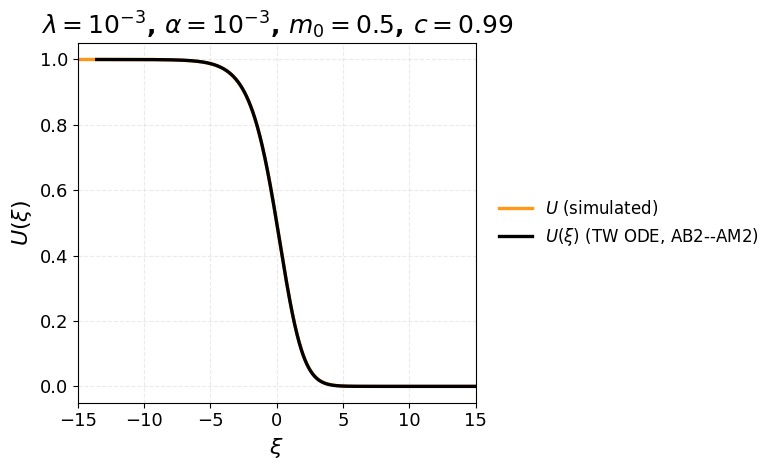

In [1]:
# ============================================
# Sim vs KPP (constant-D) overlay using c from summary.json
# AB2–AM2 (IMEX) integrator, left-tail seeding, forward marching
# ============================================
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from scipy.optimize import root_scalar

# ---------- tolerant run-dir helpers ----------
def _token_variants(v: float):
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci   = f"{v:.0e}"; s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    if not parent.exists(): return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir(): return p
    return None

def find_run_dir(base_roots, lam, alpha, m0):
    if isinstance(base_roots, (str, Path)): base_roots = (base_roots,)
    for root in base_roots:
        root = Path(root)
        d1 = _exactish_dir(root, "lambda", lam)
        if d1 is None: continue
        d2 = _exactish_dir(d1, "alpha", alpha)
        if d2 is None: continue
        d3 = _exactish_dir(d2, "m0", m0)
        if d3 is not None: return d3
    return None

# ---------- load c, m0 and snapshots ----------
def load_run(run_dir: Path):
    meta = json.loads((run_dir / "summary.json").read_text())
    z = np.load(run_dir / "snapshots.npz", allow_pickle=True)
    return dict(
        c=float(meta["wave_speed"]),
        lam=float(meta.get("lambda_val", meta.get("lambda", np.nan))),
        alpha=float(meta.get("alpha", np.nan)),
        m0=float(meta.get("m0", np.nan)),
        x=np.asarray(z["x"], float),
        times=np.asarray(z["times"], float),
        U=np.asarray(z.get("N_arr", z.get("u_arr")), float),  # tumour
    )

# ---------- U=0.5 front (monotone spline) ----------
def front_x_at_time(x, Urow, threshold=0.5, band=(0.1,0.9)):
    mask = (Urow > band[0]) & (Urow < band[1])
    if mask.sum() < 5: return None
    xloc = x[mask]; uloc = Urow[mask]
    order = np.argsort(xloc); xloc = xloc[order]; uloc = uloc[order]
    spl = PchipInterpolator(xloc, uloc, extrapolate=True)
    s = np.sign(uloc - threshold)
    idx = np.where(s[:-1]*s[1:] < 0)[0]
    if len(idx)==0: return None
    i = idx[0]; xl, xr = xloc[i], xloc[i+1]
    sol = root_scalar(lambda xv: spl(xv)-threshold, bracket=[xl,xr], method="brentq")
    return sol.root if sol.converged else None

# ---------- robust centering ----------
def _best_center_x(x, Uall, times, t_ref,
                   thresholds=(0.5, 0.45, 0.55),
                   bands=((0.1,0.9),(0.05,0.95),(0.0,1.0)),
                   time_window=120.0):
    dt = np.abs(times - t_ref)
    cand = np.argsort(dt)
    cand = [k for k in cand if (time_window is None) or (dt[k] <= time_window)]
    for k in cand:
        Urow = Uall[k]
        for thr in thresholds:
            for band in bands:
                x0 = front_x_at_time(x, Urow, threshold=thr, band=band)
                if x0 is not None:
                    return k, x0
    # fallback: nearest time, half-range threshold
    k = int(np.argmin(np.abs(times - t_ref)))
    Urow = Uall[k]
    umin, umax = float(np.nanmin(Urow)), float(np.nanmax(Urow))
    uhalf = 0.5*(umin+umax)
    x0 = front_x_at_time(x, Urow, threshold=uhalf, band=(umin+1e-12, umax-1e-12))
    return k, (x0 if x0 is not None else 0.5*(x[0]+x[-1]))

# ---------- neat formatter ----------
def _fmt_pow10(v: float):
    v = float(v)
    if np.isclose(v, 1.0):  return "1"
    if np.isclose(v, 10.0): return "10"
    if v == 0: return "0"
    k = int(np.round(np.log10(abs(v))))
    if np.isclose(v, 10.0**k):
        return rf"10^{{{k}}}"
    mant = v/(10.0**k)
    return rf"{mant:.2g}\times 10^{{{k}}}"

# ===================================================
# AB2–AM2 solver for constant-D KPP TW ODE
# U' = P
# P' = -(c/D) P - (1/D) U(1-U),  D=m0(1-m0)
# Left-tail seed at xi=-L: U=1-eps, P=-r*eps, r=(-c + sqrt(c^2+4D))/(2D)
# ===================================================
def solve_kpp_ab2am2(c, m0, L=40.0, h=0.02, eps=1e-5, max_steps=None):
    D = float(m0*(1.0 - m0))
    N = int(np.ceil(2.0*L/abs(h))) + 1
    if max_steps is not None:
        N = min(N, max_steps)
        L = 0.5*(N-1)*abs(h)

    h = abs(h)
    xi = np.linspace(-L, +L, N)

    # left-tail rate r > 0 for w=1-U: w'' + (c/D) w' - (1/D) w = 0
    r = 0.5 * (-c + np.sqrt(c*c + 4.0*D)) / D   # NOTE the /D factor

    # initial state
    U0, P0 = 1.0 - eps, -r*eps
    Y = np.zeros((2, N), float)
    Y[:, 0] = [U0, P0]

    # Heun startup (forward in xi)
    def fP(U, P):   # explicit part in P'
        return -(1.0/D)*U*(1.0-U)

    # k1
    U1 = U0 + h*P0
    P1 = P0 + h*(fP(U0, P0) - (c/D)*P0)
    # k2
    U2 = U1 + h*P1
    P2 = P1 + h*(fP(U1, P1) - (c/D)*P1)
    # average
    Ue = U0 + 0.5*h*(P0 + P1)
    Pe = P0 + 0.5*h*((fP(U0, P0) - (c/D)*P0) + (fP(U1, P1) - (c/D)*P1))
    Y[:, 1] = [Ue, Pe]

    # AB2–AM2 march
    fU_prev, fP_prev = P0, fP(U0, P0)
    fU_curr, fP_curr = Pe, fP(Ue, Pe)

    for n in range(1, N-1):
        U_n, P_n = Y[:, n]

        # U (explicit AB2)
        U_next = U_n + h*(1.5*fU_curr - 0.5*fU_prev)

        # P (AB2 on explicit part, AM2 on linear -(c/D)P)
        P_AB2  = P_n + h*(1.5*fP_curr - 0.5*fP_prev)
        P_next = (P_AB2 - 0.5*h*(c/D)*P_n) / (1.0 + 0.5*h*(c/D))

        Y[:, n+1] = [U_next, P_next]

        # shift explicitly
        fU_prev, fP_prev = fU_curr, fP_curr
        fU_curr = P_next
        fP_curr = fP(U_next, P_next)

    return xi, Y[0]

# ---------- main overlay ----------
def overlay_sim_vs_kpp_ab2(
    base_roots, lam, alpha, m0, t_ref,
    time_window=120.0,
    xi_span_factor=12.0, xi_min_span=15.0,
    h=0.02, L_pad_factor=1.5, eps=1e-5,
    max_auto_attempts=5, L_growth=1.8, eps_growth=5.0,
    figsize=(7.9,4.8), tumor_color="#ff8c00",
    kpp_style={"color":"k","ls":"-","lw":2.4},
    label_fs=16, tick_fs=13, title_fs=18, verbose=False
):
    run_dir = find_run_dir(base_roots, lam, alpha, m0)
    if run_dir is None: raise FileNotFoundError("Run not found for given (λ, α, m0).")
    data = load_run(run_dir)
    c, x, T, Uall = data["c"], data["x"], data["times"], data["U"]
    m0 = float(data["m0"])

    # center simulation
    k, x0 = _best_center_x(x, Uall, T, t_ref)
    xi_num = x - x0

    # choose ξ half-span
    xi_half = max(xi_span_factor*abs(c), xi_min_span)

    # integrate KPP TW (auto-expand until 0.5 crossing)
    L_try, eps_try = float(xi_half)*L_pad_factor, float(eps)
    for attempt in range(max_auto_attempts):
        xi_kpp, U_kpp = solve_kpp_ab2am2(c, m0, L=L_try, h=h, eps=eps_try)
        x0_kpp = front_x_at_time(xi_kpp, U_kpp, threshold=0.5, band=(0.05,0.95))
        if x0_kpp is not None: break
        if verbose:
            print(f"[AB2–AM2] attempt {attempt+1}: no crossing; L->{L_try*L_growth:.3g}, eps->{eps_try*eps_growth:g}")
        L_try *= L_growth; eps_try *= eps_growth
    xi_kpp_cent = xi_kpp - (x0_kpp if x0_kpp is not None else 0.0)

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(xi_num, Uall[k], color=tumor_color, lw=2.4, alpha=0.9, label=r"$U$ (simulated)")
    ax.plot(xi_kpp_cent, U_kpp, **kpp_style, label=r"$U(\xi)$ (TW ODE, AB2--AM2)")

    ax.set_xlim(-xi_half, +xi_half)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, ls="--", alpha=0.25)
    ax.set_xlabel(r"$\xi$", fontsize=label_fs)
    ax.set_ylabel(r"$U(\xi)$", fontsize=label_fs)
    ax.tick_params(labelsize=tick_fs)

    ttl = rf"$\lambda={_fmt_pow10(lam)}$, $\alpha={_fmt_pow10(alpha)}$, $m_0={m0:g}$, $c={c:.3g}$"
    ax.set_title(ttl, fontsize=title_fs, fontweight="bold")
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=12)
    fig.tight_layout()
    plt.show()
    return fig, ax

# ------------------------------
# Example: one panel
# ------------------------------
if __name__ == "__main__":
    BASES = ("speeds_func_4", "speeds_func_l", "speeds_func_u")
    lam, alpha, m0 = 1e-3, 1e-3, 0.5
    t_ref = 100
    overlay_sim_vs_kpp_ab2(
        BASES, lam, alpha, m0, t_ref,
        time_window=120.0,
        xi_span_factor=12.0,
        xi_min_span=15.0,
        h=0.02, L_pad_factor=1.5, eps=1e-5,
        verbose=True
    )

In [2]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from scipy.optimize import root_scalar

# ----------------- small helpers -----------------
def _is_scalar(x):
    try:
        float(x)
        return True
    except Exception:
        return False

def _row_len(row):
    a, b = row
    if _is_scalar(a) and not _is_scalar(b):   # (alpha, [lambdas])
        return len(b)
    if not _is_scalar(a) and _is_scalar(b):   # ([alphas], lambda)
        return len(a)
    raise ValueError("Each row must be (alpha_scalar, [lambdas]) or ([alphas], lambda_scalar).")

def _fmt_pow10(v: float):
    v = float(v)
    if np.isclose(v, 1.0):  return "1"
    if np.isclose(v, 10.0): return "10"
    if v == 0: return "0"
    k = int(np.round(np.log10(abs(v))))
    if np.isclose(v, 10.0**k):
        return rf"10^{{{k}}}"
    mant = v/(10.0**k)
    return rf"{mant:.2g}\times 10^{{{k}}}"

def _token_variants(v: float):
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci   = f"{v:.0e}"; s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    if not parent.exists(): return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir(): return p
    return None

def find_run_dir(base_roots, lam, alpha, m0):
    if isinstance(base_roots, (str, Path)): base_roots = (base_roots,)
    for root in base_roots:
        root = Path(root)
        d1 = _exactish_dir(root, "lambda", lam)
        if d1 is None: continue
        d2 = _exactish_dir(d1, "alpha", alpha)
        if d2 is None: continue
        d3 = _exactish_dir(d2, "m0", m0)
        if d3 is not None: return d3
    return None

def load_run(run_dir: Path):
    meta = json.loads((run_dir / "summary.json").read_text())
    z = np.load(run_dir / "snapshots.npz", allow_pickle=True)
    return dict(
        c=float(meta["wave_speed"]),
        lam=float(meta.get("lambda_val", meta.get("lambda", np.nan))),
        alpha=float(meta.get("alpha", np.nan)),
        m0=float(meta.get("m0", np.nan)),
        x=np.asarray(z["x"], float),
        times=np.asarray(z["times"], float),
        U=np.asarray(z.get("N_arr", z.get("u_arr")), float),
    )

def front_x_at_time(x, Urow, threshold=0.5, band=(0.1,0.9)):
    mask = (Urow > band[0]) & (Urow < band[1])
    if mask.sum() < 5: return None
    xloc = x[mask]; uloc = Urow[mask]
    o = np.argsort(xloc); xloc = xloc[o]; uloc = uloc[o]
    spl = PchipInterpolator(xloc, uloc, extrapolate=True)
    s = np.sign(uloc - threshold)
    idx = np.where(s[:-1]*s[1:] < 0)[0]
    if len(idx)==0: return None
    i = idx[0]; xl, xr = xloc[i], xloc[i+1]
    sol = root_scalar(lambda xv: spl(xv)-threshold, bracket=[xl,xr], method="brentq")
    return sol.root if sol.converged else None

def _best_center_x(x, Uall, times, t_ref,
                   thresholds=(0.5, 0.45, 0.55),
                   bands=((0.1,0.9),(0.05,0.95),(0.0,1.0)),
                   time_window=120.0):
    dt = np.abs(times - t_ref)
    cand = np.argsort(dt)
    cand = [k for k in cand if (time_window is None) or (dt[k] <= time_window)]
    for k in cand:
        Urow = Uall[k]
        for thr in thresholds:
            for band in bands:
                x0 = front_x_at_time(x, Urow, threshold=thr, band=band)
                if x0 is not None:
                    return k, x0
    k = int(np.argmin(np.abs(times - t_ref)))
    Urow = Uall[k]
    umin, umax = float(np.nanmin(Urow)), float(np.nanmax(Urow))
    uhalf = 0.5*(umin+umax)
    x0 = front_x_at_time(x, Urow, threshold=uhalf, band=(umin+1e-12, umax-1e-12))
    return k, (x0 if x0 is not None else 0.5*(x[0]+x[-1]))

# ----------------- AB2–AM2 solver for constant-D KPP -----------------
# U' = P
# P' = -(c/D) P - (1/D) U(1-U)
# seed at xi=-L: U=1-eps, P=-r*eps, r = (-c + sqrt(c^2 + 4D)) / (2D)
def solve_kpp_ab2am2(c, D, L=40.0, h=0.02, eps=1e-5):
    N = int(np.ceil(2.0*L/abs(h))) + 1
    h = abs(h)
    xi = np.linspace(-L, +L, N)

    r = 0.5 * (-c + np.sqrt(c*c + 4.0*D)) / D  # left-tail rate > 0
    U0, P0 = 1.0 - eps, -r*eps

    Y = np.zeros((2, N), float)
    Y[:, 0] = [U0, P0]

    def fP(U):  # explicit part
        return -(1.0/D)*U*(1.0-U)

    # Heun startup
    U1 = U0 + h*P0
    P1 = P0 + h*(fP(U0) - (c/D)*P0)
    U2 = U1 + h*P1
    P2 = P1 + h*(fP(U1) - (c/D)*P1)
    Ue = U0 + 0.5*h*(P0 + P1)
    Pe = P0 + 0.5*h*((fP(U0) - (c/D)*P0) + (fP(U1) - (c/D)*P1))
    Y[:, 1] = [Ue, Pe]

    fU_prev, fP_prev = P0, fP(U0)
    fU_curr, fP_curr = Pe, fP(Ue)

    for n in range(1, N-1):
        U_n, P_n = Y[:, n]

        # U: AB2
        U_next = U_n + h*(1.5*fU_curr - 0.5*fU_prev)

        # P: AB2 on explicit, AM2 on -(c/D)P
        P_AB2  = P_n + h*(1.5*fP_curr - 0.5*fP_prev)
        P_next = (P_AB2 - 0.5*h*(c/D)*P_n) / (1.0 + 0.5*h*(c/D))

        Y[:, n+1] = [U_next, P_next]

        fU_prev, fP_prev = fU_curr, fP_curr
        fU_curr = P_next
        fP_curr = fP(U_next)

    return xi, Y[0]

# ----------------- overlay on one axes (sim vs AB2 curve) -----------------
def overlay_one(ax, run_dir, t_ref,
                tumor_color="#ff8c00", logistic_color="k",
                ab2_curve="logistic",      # "logistic" -> D=1, "kpp" -> D=m0(1-m0)
                h=0.02, L_pad=1.5, eps=1e-5,
                xi_span_factor=12.0, xi_min_span=15.0):
    data = load_run(run_dir)
    c, x, T, Uall, m0 = data["c"], data["x"], data["times"], data["U"], float(data["m0"])

    # center the simulation at t_ref by its own U=0.5
    k, x0 = _best_center_x(x, Uall, T, t_ref)
    xi_num = x - x0

    # choose D
    if ab2_curve == "logistic":
        D = 1.0
    elif ab2_curve == "kpp":
        D = m0*(1.0 - m0)
    else:
        raise ValueError('ab2_curve must be "logistic" or "kpp".')

    xi_half = max(xi_span_factor*abs(c), xi_min_span)

    # integrate a bit beyond window
    L = float(xi_half)*L_pad
    xi_ab2, U_ab2 = solve_kpp_ab2am2(c, D, L=L, h=h, eps=eps)

    # center AB2 curve by its own U=0.5
    x0_ab2 = front_x_at_time(xi_ab2, U_ab2, threshold=0.5, band=(0.05, 0.95))
    xi_ab2_cent = xi_ab2 - (x0_ab2 if x0_ab2 is not None else 0.0)

    # plot
    (sim_line,) = ax.plot(xi_num, Uall[k], color=tumor_color, lw=2.4, label=r"$U$ (simulated)")
    (ab2_line,) = ax.plot(xi_ab2_cent, U_ab2, color=logistic_color, lw=2.4,
                          label=(r"$U(\xi)$ (TW ODE, AB2--AM2)"))

    ax.set_xlim(-xi_half, +xi_half)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, ls="--", alpha=0.25)

    return (sim_line, ab2_line)

# ----------------- your grid function, now using AB2–AM2 -----------------
def plot_asymptotic_grid(base_roots, rows, m0, t_ref,
                         figsize=(12, 6.5),
                         tumor_color="#ff8c00", logistic_color="k",
                         sharey=True, sharex=True,
                         suptitle=None, left_ylabel=r"$U(\xi)$",
                         bottom_xlabel=r"$\xi$",
                         ab2_curve="logistic",   # "logistic" (D=1) or "kpp" (D=m0(1-m0))
                         h=0.02, L_pad=1.5, eps=1e-5,
                         xi_span_factor=12.0, xi_min_span=15.0):
    """
    rows: list where each element is either
          (alpha_scalar, [lambda_1, lambda_2, ...])  or
          ([alpha_1, alpha_2, ...], lambda_scalar).

    ab2_curve:
      - "logistic": AB2–AM2 with D=1
      - "kpp":      AB2–AM2 with D=m0(1-m0)
    """
    nrows = len(rows)
    ncols = max(_row_len(r) for r in rows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False,
                             sharex=sharex, sharey=sharey)

    legend_handles = None

    for i, row in enumerate(rows):
        A, B = row
        if _is_scalar(A) and not _is_scalar(B):
            fixed_alpha = float(A)
            lam_list    = list(B)
            alpha_list  = None
        elif not _is_scalar(A) and _is_scalar(B):
            alpha_list  = list(A)
            fixed_lambda = float(B)
            lam_list    = None
        else:
            raise ValueError(
                "Row must be (alpha_scalar, [lambdas]) or ([alphas], lambda_scalar)."
            )

        for j in range(ncols):
            ax = axes[i, j]
            # hide excess panels
            if (_is_scalar(A) and not _is_scalar(B) and j >= len(lam_list)) or \
               (not _is_scalar(A) and _is_scalar(B) and j >= len(alpha_list)):
                ax.set_axis_off()
                continue

            if lam_list is not None:
                lam = lam_list[j]; alpha = fixed_alpha
            else:
                alpha = alpha_list[j]; lam = fixed_lambda

            run_dir = find_run_dir(base_roots, lam, alpha, m0)
            if run_dir is None:
                ax.text(0.5, 0.5, "(run not found)", ha="center", va="center",
                        transform=ax.transAxes)
                ax.set_axis_off()
                continue

            lines = overlay_one(
                ax, run_dir, t_ref,
                tumor_color=tumor_color, logistic_color=logistic_color,
                ab2_curve=ab2_curve, h=h, L_pad=L_pad, eps=eps,
                xi_span_factor=xi_span_factor, xi_min_span=xi_min_span
            )
            if lines and legend_handles is None:
                legend_handles = lines

            ttl = rf"$\alpha={_fmt_pow10(alpha)}$, $\lambda={_fmt_pow10(lam)}$"
            ax.set_title(ttl, fontsize=13)

            if i == nrows - 1:
                ax.set_xlabel(bottom_xlabel, fontsize=14)
            if j == 0:
                ax.set_ylabel(left_ylabel, fontsize=14)

    if legend_handles is not None:
        fig.legend(legend_handles, [h.get_label() for h in legend_handles],
                   loc="center left", bbox_to_anchor=(.87, 0.5),
                   frameon=False, fontsize=12)

    fig.tight_layout(rect=[0.06, 0.06, 0.88, 0.95])
    if suptitle:
        fig.suptitle(suptitle, y=0.995, fontsize=15, fontweight="bold")
    plt.show()
    return fig, axes

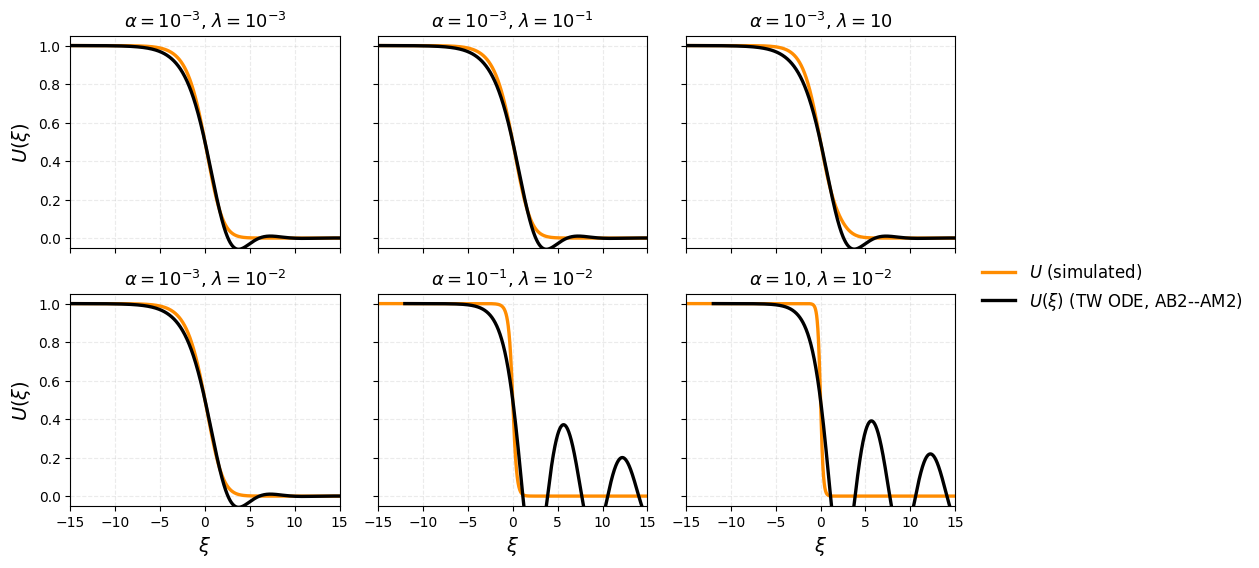

(<Figure size 1200x650 with 6 Axes>,
 array([[<Axes: title={'center': '$\\alpha=10^{-3}$, $\\lambda=10^{-3}$'}, ylabel='$U(\\xi)$'>,
         <Axes: title={'center': '$\\alpha=10^{-3}$, $\\lambda=10^{-1}$'}>,
         <Axes: title={'center': '$\\alpha=10^{-3}$, $\\lambda=10$'}>],
        [<Axes: title={'center': '$\\alpha=10^{-3}$, $\\lambda=10^{-2}$'}, xlabel='$\\xi$', ylabel='$U(\\xi)$'>,
         <Axes: title={'center': '$\\alpha=10^{-1}$, $\\lambda=10^{-2}$'}, xlabel='$\\xi$'>,
         <Axes: title={'center': '$\\alpha=10$, $\\lambda=10^{-2}$'}, xlabel='$\\xi$'>]],
       dtype=object))

In [3]:
BASES = ("speeds_func_4", "speeds_func_l", "speeds_func_u")
rows = [
    (1e-3, [1e-3, 1e-1, 1e1]),   # fixed alpha, sweep lambdas
    ([1e-3, 1e-1, 1e1], 1e-2),   # sweep alphas, fixed lambda
]
plot_asymptotic_grid(
    BASES, rows, m0=0.5, t_ref=100,
    ab2_curve="logistic",   # <- D = 1
    h=0.02, L_pad=1.5, eps=1e-5
)